<a href="https://colab.research.google.com/github/Nikhila-KS/Unravel_ML/blob/main/LungSoundClassification_Mboalab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit
import shutil
from tqdm import tqdm
from keras.optimizers import Adam

In [2]:
print(tf.__version__)

2.12.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Upload data
from zipfile import ZipFile
file_name = '/content/drive/My Drive/LungSounds.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

Mounted at /content/drive
done


[LINK FOR ZIP FILE](https://drive.google.com/file/d/1SLjT10kuwnVwXaWDlPSJ6r9NUUhgrs_I/view?usp=sharing)

In [4]:

df_no_diagnosis = pd.read_csv('/content/LungSounds/archive/demographic_info.txt',
                              names =['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], delimiter = ' ')

diagnosis = pd.read_csv('/content/LungSounds/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',
                        names = ['Patient number', 'Diagnosis'])

In [5]:
data_path = '/content/LungSounds/archive/'
parent_data_path = "/content/LungSounds/"
encode = LabelEncoder()
#used by several instances, You need to call fit(...) or fit_transform(...) on your LabelEncoder before you can

In [6]:
df_no_diagnosis

Patient number    Age  Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
0               101   3.00    F                NaN               19.0   
1               102   0.75    F                NaN                9.8   
2               103  70.00    F              33.00                NaN   
3               104  70.00    F              28.47                NaN   
4               105   7.00    F                NaN               32.0   
..              ...    ...  ...                ...                ...   
121             222  60.00    M                NaN                NaN   
122             223    NaN  NaN                NaN                NaN   
123             224  10.00    F                NaN               32.3   
124             225   0.83    M                NaN                7.8   
125             226   4.00    M                NaN               16.7   

     Child Height (cm)  
0                 99.0  
1                 73.0  
2                  NaN  
3                  NaN  
4                135.0  
..                 ...  
121                NaN  
122                NaN  
123              143.0  
124               74.0  
125              103.0  

[126 rows x 6 columns]

In [7]:
diagnosis

Patient number  Diagnosis
0               101       URTI
1               102    Healthy
2               103     Asthma
3               104       COPD
4               105       URTI
..              ...        ...
121             222       COPD
122             223       COPD
123             224    Healthy
124             225    Healthy
125             226  Pneumonia

[126 rows x 2 columns]

In [8]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [9]:
df

Patient number    Age  Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
0               101   3.00    F                NaN               19.0   
1               102   0.75    F                NaN                9.8   
2               103  70.00    F              33.00                NaN   
3               104  70.00    F              28.47                NaN   
4               105   7.00    F                NaN               32.0   
..              ...    ...  ...                ...                ...   
121             222  60.00    M                NaN                NaN   
122             223    NaN  NaN                NaN                NaN   
123             224  10.00    F                NaN               32.3   
124             225   0.83    M                NaN                7.8   
125             226   4.00    M                NaN               16.7   

     Child Height (cm)  Diagnosis  
0                 99.0       URTI  
1                 73.0    Healthy  
2                  NaN     Asthma  
3                  NaN       COPD  
4                135.0       URTI  
..                 ...        ...  
121                NaN       COPD  
122                NaN       COPD  
123              143.0    Healthy  
124               74.0    Healthy  
125              103.0  Pneumonia  

[126 rows x 7 columns]

In [10]:
root = '/content/LungSounds/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [11]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [12]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

Patient number Recording index Chest location Acquisition mode  \
0            112             1b1             Ar               sc   
0            135             2b3             Pl               mc   
0            130             1p2             Al               mc   
0            186             2b3             Lr               mc   
0            114             1b4             Ar               mc   

  Recording equipment  
0            Meditron  
0            LittC2SE  
0            AKGC417L  
0            AKGC417L  
0            AKGC417L

In [13]:
rec_annotations

[     Start      End  Crackles  Wheezes
 0   1.9099   3.8871         1        1
 1   3.8871   5.6357         0        0
 2   5.6357   7.5860         0        0
 3   7.5860   9.3816         0        0
 4   9.3816  11.2650         0        0
 5  11.2650  13.3970         0        0
 6  13.3970  18.5550         0        0
 7  18.5550  20.8480         0        0,
     Start     End  Crackles  Wheezes
 0   1.018   3.411         1        0
 1   3.411   5.827         1        0
 2   5.827   8.339         1        1
 3   8.339  10.923         1        0
 4  10.923  13.292         0        1
 5  13.292  16.018         1        0
 6  16.018  18.482         1        0
 7  18.482  19.542         1        0,
     Start     End  Crackles  Wheezes
 0   1.010   3.581         0        0
 1   3.581   6.836         0        1
 2   6.836   9.624         1        0
 3   9.624  12.262         0        0
 4  12.262  15.801         0        1
 5  15.801  18.322         0        0
 6  18.322  19.274         0  

In [14]:
rec_annotations_dict

{'139_1b1_Ll_sc_Litt3200':      Start      End  Crackles  Wheezes
 0   1.9099   3.8871         1        1
 1   3.8871   5.6357         0        0
 2   5.6357   7.5860         0        0
 3   7.5860   9.3816         0        0
 4   9.3816  11.2650         0        0
 5  11.2650  13.3970         0        0
 6  13.3970  18.5550         0        0
 7  18.5550  20.8480         0        0,
 '107_2b4_Al_mc_AKGC417L':     Start     End  Crackles  Wheezes
 0   1.018   3.411         1        0
 1   3.411   5.827         1        0
 2   5.827   8.339         1        1
 3   8.339  10.923         1        0
 4  10.923  13.292         0        1
 5  13.292  16.018         1        0
 6  16.018  18.482         1        0
 7  18.482  19.542         1        0,
 '172_1b5_Pr_mc_AKGC417L':     Start     End  Crackles  Wheezes
 0   1.010   3.581         0        0
 1   3.581   6.836         0        1
 2   6.836   9.624         1        0
 3   9.624  12.262         0        0
 4  12.262  15.801         0

In [15]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [16]:
file_label_df = pd.DataFrame(data = {'filename':filename_list})
file_label_df

filename
0    139_1b1_Ll_sc_Litt3200
1    107_2b4_Al_mc_AKGC417L
2    172_1b5_Pr_mc_AKGC417L
3    133_2p2_Ar_mc_AKGC417L
4    112_1b1_Lr_sc_Meditron
..                      ...
915  112_1b1_Ar_sc_Meditron
916  135_2b3_Pl_mc_LittC2SE
917  130_1p2_Al_mc_AKGC417L
918  186_2b3_Lr_mc_AKGC417L
919  114_1b4_Ar_mc_AKGC417L

[920 rows x 1 columns]

In [17]:
audio_path = '/content/LungSounds/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'

In [18]:
# adding columns in file_label_df
diagnosis_list = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []

for i in tqdm(range(len(file_label_df['filename']))):
  info = file_label_df['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info
  #sound_filename = audio_path + file_label_df['filename'][i] + '.wav'
  #x, sr = librosa.load(sound_filename)
  #dur = round(x.shape[0]/sr, 2)
  #sample_rate.append(sr)
  #duration.append(dur)

  diagnosis_list.append(df['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)

file_label_df['Diagnosis'] = diagnosis_list
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment
#file_label_df['duration'] = duration
#file_label_df['sample rate'] = sample_rate

100%|██████████| 920/920 [00:00<00:00, 50701.10it/s]


In [19]:
file_label_df

filename  Diagnosis Patient Number Chest Location  \
0    139_1b1_Ll_sc_Litt3200       COPD            139             Ll   
1    107_2b4_Al_mc_AKGC417L       COPD            107             Al   
2    172_1b5_Pr_mc_AKGC417L       COPD            172             Pr   
3    133_2p2_Ar_mc_AKGC417L       COPD            133             Ar   
4    112_1b1_Lr_sc_Meditron       COPD            112             Lr   
..                      ...        ...            ...            ...   
915  112_1b1_Ar_sc_Meditron       COPD            112             Ar   
916  135_2b3_Pl_mc_LittC2SE  Pneumonia            135             Pl   
917  130_1p2_Al_mc_AKGC417L       COPD            130             Al   
918  186_2b3_Lr_mc_AKGC417L       COPD            186             Lr   
919  114_1b4_Ar_mc_AKGC417L       COPD            114             Ar   

    Acquisition Mode Recording Equipment  
0                 sc            Litt3200  
1                 mc            AKGC417L  
2                 mc            AKGC417L  
3                 mc            AKGC417L  
4                 sc            Meditron  
..               ...                 ...  
915               sc            Meditron  
916               mc            LittC2SE  
917               mc            AKGC417L  
918               mc            AKGC417L  
919               mc            AKGC417L  

[920 rows x 6 columns]

In [20]:
file_label_df['Diagnosis'].value_counts()

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: Diagnosis, dtype: int64

## Exploratory Data Analysis

In [21]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read

In [22]:
i = 111
sound_filename = audio_path +'/'+ file_label_df['filename'][i] + '.wav'


In [23]:
def waveform(file_path, label):
  y, sr = librosa.load(file_path, sr=16000)
  plt.figure(figsize=(16, 3))
  plt.title(label + ' Sound Wave')
  librosa.display.waveshow(y)

In [24]:
import IPython.display as ipd
ipd.Audio(filename=sound_filename, rate=16000)

In [25]:
# diagnosis.get(["Patient number", 'Diagnosis'])
diagnosis.get('Diagnosis')[0]
# diagnosis[0]
# va
# diagnosis.get('Diagnosis')[101]

def getDiagnosis(patient_id):
    for index, row in diagnosis.iterrows():
      if(row['Patient number']==patient_id):
         y = row['Diagnosis']
         return y


getDiagnosis(i)

'Bronchiectasis'

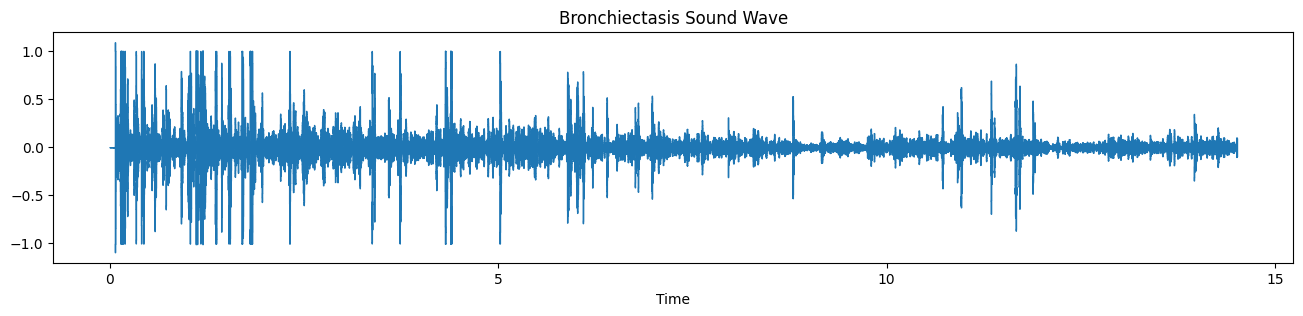

In [26]:
waveform(sound_filename, getDiagnosis(i))


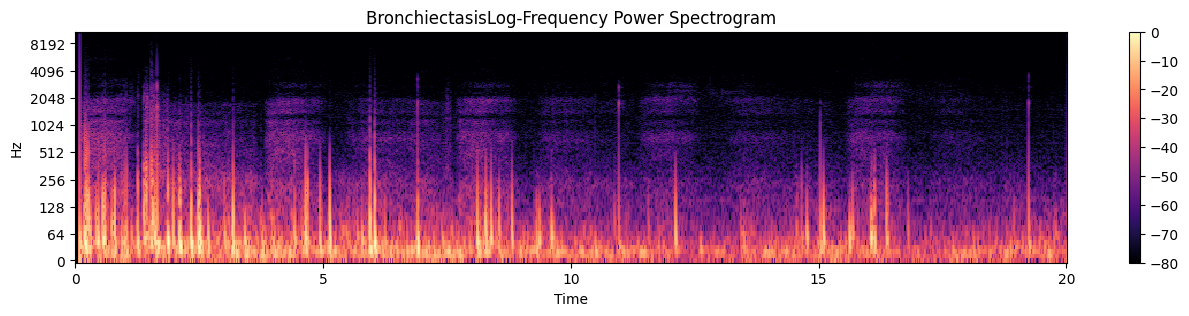

In [27]:
def spectrogram(file_path, label):
    y, sr = librosa.load(file_path)
    plt.figure(figsize=(16,3))
    plt.title(label + 'Log-Frequency Power Spectrogram')
    data = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(data, y_axis='log', x_axis='time')
    plt.colorbar();



# Spectogram data
spectrogram(sound_filename, getDiagnosis(i))


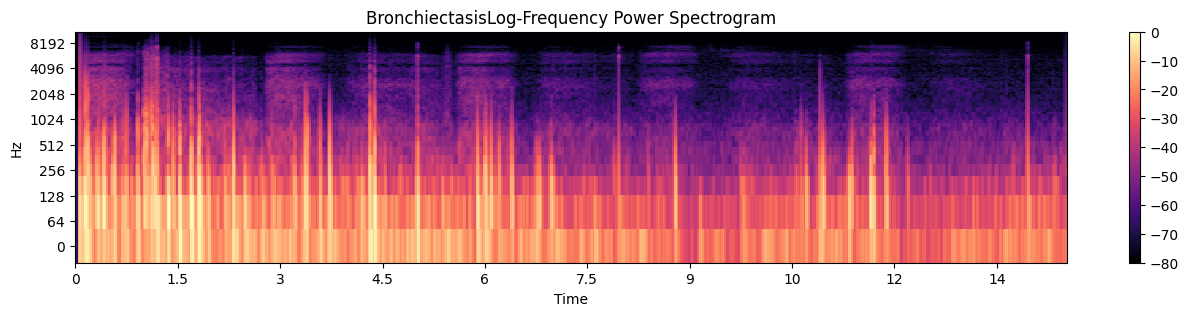

In [28]:
def log_spectrogram(file_path, label):
    y, sr = librosa.load(sound_filename, sr=16000)
    plt.figure(figsize=(16,3))
    plt.title(getDiagnosis(i) + 'Log-Frequency Power Spectrogram')
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    librosa.display.specshow(log_mel, y_axis='log', x_axis='time')
    plt.colorbar();

# Log-mel spectogram
log_spectrogram(sound_filename, getDiagnosis(i))

In [29]:
#removes/drops the following columns, when run twice, it will throw an error since the columns would have been dropped.
file_label_df = file_label_df.drop(['Patient Number', 'Chest Location', 'Acquisition Mode', 'Recording Equipment'],  axis=1)

In [30]:
file_label_df


filename  Diagnosis
0    139_1b1_Ll_sc_Litt3200       COPD
1    107_2b4_Al_mc_AKGC417L       COPD
2    172_1b5_Pr_mc_AKGC417L       COPD
3    133_2p2_Ar_mc_AKGC417L       COPD
4    112_1b1_Lr_sc_Meditron       COPD
..                      ...        ...
915  112_1b1_Ar_sc_Meditron       COPD
916  135_2b3_Pl_mc_LittC2SE  Pneumonia
917  130_1p2_Al_mc_AKGC417L       COPD
918  186_2b3_Lr_mc_AKGC417L       COPD
919  114_1b4_Ar_mc_AKGC417L       COPD

[920 rows x 2 columns]

In [31]:
#Counting the number of lables in the dataframe
file_label_df.Diagnosis.value_counts()

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: Diagnosis, dtype: int64

In [32]:
def data_distribution(data):
    plt.figure(figsize=(16,3))
    data.Diagnosis.value_counts().plot(kind='bar', title="Data Category distribution")
    plt.show()

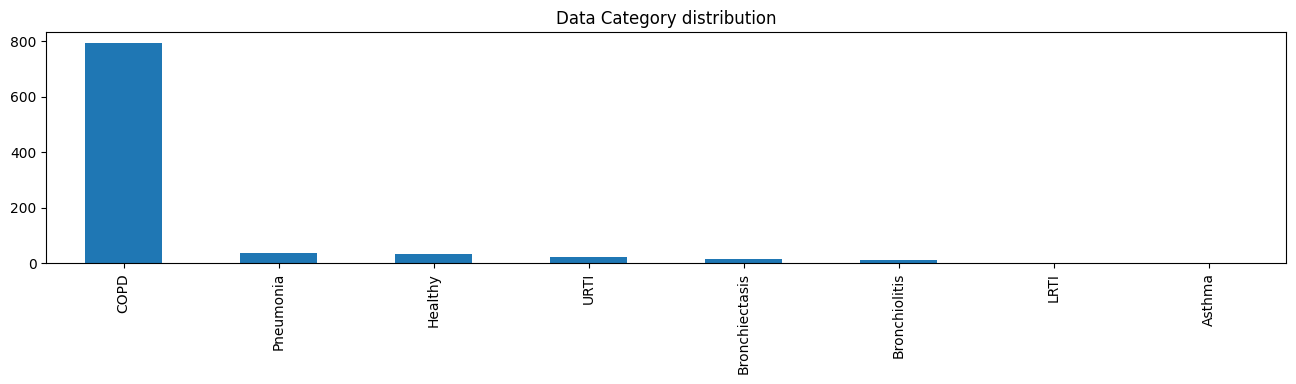

In [33]:
#Data Distribution Graph
data_distribution(file_label_df)

In [34]:
def get_fileNames(path):
       fileNames = [file for file in glob.glob(path)]
       return fileNames

In [35]:
def changing_speed(speed_rate, src_path, dst_path):
    files = get_fileNames(src_path + "//**")
    if not os.path.exists(dst_path):
      os.makedirs(dst_path)
    for file in tqdm(files):
      label = os.path.basename(file).split('.')[0]
      y, sr = librosa.load(file)
      updated_y = librosa.effects.time_stretch(y, rate=speed_rate)
      soundfile.write(dst_path + '//' + label + '_' + str(speed_rate) + ".wav", updated_y, sr)

In [36]:
def sound_augmentation(src_path, dst_path):
    speed_rates = [1.08, 0.8, 1.10, 0.9]
    for speed_rate in speed_rates:
        changing_speed(speed_rate, src_path, dst_path)

    files = get_fileNames(src_path + '//**')
    for f in files:
      shutil.copy(f, dst_path)

In [37]:
#Create working directory and Data2 directory
os.mkdir('working')
os.chdir('working')
os.mkdir('Data2')

In [38]:
#copies files from folder into Data2, these folders in the context of our training are set_a and set_b
def fill_folder1_toData2(folder_name): #folder1: set_a , folder2: set_b
    source = '/content/LungSounds/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
    # data_path+folder_name
    destination = '/content/working/Data2'
    # data_path+'working/Data2/'

    # Get a list of files in the source directory
    file_list = os.listdir(source)

    # Iterate over the files and copy them to the destination directory
    for file_name in file_list:
        source_file = os.path.join(source, file_name)
        destination_file = os.path.join(destination, file_name)
        if(file_name.endswith('.wav')):
          shutil.copy2(source_file, destination_file)

In [39]:
#move to desired working directory, preferably where your datasets sits
# os.chdir(data_path)
# os.getcwdb()
get_fileNames('/content/LungSounds/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_file/')

#copy files in set_a and set_b files into working/Data2 folder
fill_folder1_toData2("Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_file")

In [40]:
# os.chdir(data_path+'working/')
os.chdir('/content/working')
os.mkdir('OUT')

In [41]:
def create_new_augmented_data_files():
    # Checking and creating new directory for saving newly generated audio files using data augmentation
    if os.path.exists('/content/working/OUT'):  #data_path+'working/OUT'
      if len(get_fileNames('/content/working/OUT//**')) == 4175:
          print('Sound Augmentation Already Done and Saved')
      else:
          shutil.rmtree('/content/working/OUT')
          sound_augmentation('/content/working/Data2', '/content/working/OUT')
    else:
        sound_augmentation('/content/working/Data2', '/content/working/OUT')

In [42]:
#Checking and creating new directory for saving newly generated audio files using data augmentation(speed and pitch change)
create_new_augmented_data_files()


100%|██████████| 920/920 [04:55<00:00,  3.11it/s]


In [43]:
def create_dataframe(dataframe_name, folder_path_list):
    audio = {'file_path': [], 'diagnosis': []}
    final_diagnosis = []
    for filename in os.listdir('/content/working/OUT'):
      file = os.path.join('/content/working/OUT', filename)
      # checking if it is a file
      if os.path.isfile(file):
        final_diagnosis = getDiagnosis(int(os.path.basename(file).split('_')[0]))
        if((librosa.get_duration(path=file)>3)):
            audio['file_path'].append(file)
            audio['diagnosis'].append(final_diagnosis)
    dataframe_name = pd.DataFrame(audio)
    return dataframe_name


final_df = create_dataframe('final_df', '/content/working/OUT')
final_df

file_path diagnosis
0     /content/working/OUT/194_1b1_Pr_sc_Meditron_1....   Healthy
1     /content/working/OUT/110_1p1_Lr_sc_Meditron_1....      COPD
2     /content/working/OUT/160_1b3_Pr_mc_AKGC417L_1....      COPD
3       /content/working/OUT/172_1b3_Al_mc_AKGC417L.wav      COPD
4     /content/working/OUT/106_2b1_Pr_mc_LittC2SE_0....      COPD
...                                                 ...       ...
4595  /content/working/OUT/114_1b4_Lr_mc_AKGC417L_1....      COPD
4596  /content/working/OUT/147_1b3_Tc_mc_AKGC417L_1....      COPD
4597  /content/working/OUT/158_2p3_Tc_mc_AKGC417L_1....      COPD
4598  /content/working/OUT/186_3b3_Lr_mc_AKGC417L_0....      COPD
4599  /content/working/OUT/174_1p4_Ar_mc_AKGC417L_0....      COPD

[4600 rows x 2 columns]

In [44]:
final_df['diagnosis'].value_counts()

COPD              3965
Pneumonia          185
Healthy            175
URTI               115
Bronchiectasis      80
Bronchiolitis       65
LRTI                10
Asthma               5
Name: diagnosis, dtype: int64

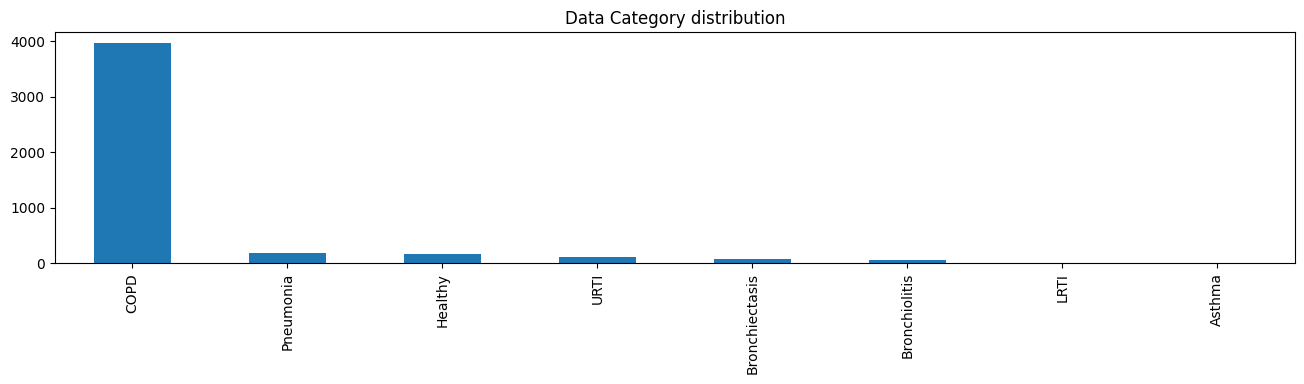

In [45]:
#Data Distribution Graph
def data_distribution_final(data):
    plt.figure(figsize=(16,3))
    data.diagnosis.value_counts().plot(kind='bar', title="Data Category distribution")
    plt.show()

data_distribution_final(final_df)

In [46]:
#Splits data into training and testing
def split_for_training_testing(final_data):
    # Splitting the Data into Training Data and Testing Data in the proportion of 80:20 (Train:Test)
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in split.split(final_data, final_data.diagnosis):
        train_data = final_data.loc[train_idx]
        test_data = final_data.loc[test_idx]
        return [train_data, test_data]

In [47]:
#get both train and test data
split_train_test_data = split_for_training_testing(final_df)

#creates variables to hold both train and test data and initilizes both of them
train_data = split_train_test_data[0]
test_data = split_train_test_data[1]

In [48]:
#displays total training data
train_data

file_path       diagnosis
2248    /content/working/OUT/116_1b2_Pl_sc_Meditron.wav  Bronchiectasis
2981  /content/working/OUT/185_1b1_Lr_sc_Litt3200_0....            COPD
1578  /content/working/OUT/154_1b3_Pl_mc_AKGC417L_1....            COPD
1521  /content/working/OUT/205_4b2_Al_mc_AKGC417L_0....            COPD
180   /content/working/OUT/130_3p4_Pr_mc_AKGC417L_0....            COPD
...                                                 ...             ...
3470  /content/working/OUT/133_2p4_Pl_mc_AKGC417L_0....            COPD
880   /content/working/OUT/156_2b3_Pl_mc_AKGC417L_1....            COPD
2370  /content/working/OUT/192_2b3_Al_mc_LittC2SE_0....            COPD
4188  /content/working/OUT/158_1p2_Tc_mc_AKGC417L_1....            COPD
2031    /content/working/OUT/130_3p2_Pl_mc_AKGC417L.wav            COPD

[3680 rows x 2 columns]

In [49]:
#displays total testing data
test_data

file_path      diagnosis
3666  /content/working/OUT/157_1b1_Al_sc_Meditron_1....           COPD
1449  /content/working/OUT/203_1p4_Tc_mc_AKGC417L_1....           COPD
14    /content/working/OUT/222_1b1_Ar_sc_Meditron_1....           COPD
3671  /content/working/OUT/198_6p1_Pr_mc_AKGC417L_0....           COPD
4216  /content/working/OUT/162_2b2_Pr_mc_AKGC417L_0....           COPD
...                                                 ...            ...
1338  /content/working/OUT/147_2b3_Lr_mc_AKGC417L_0....           COPD
54      /content/working/OUT/114_1b4_Al_mc_AKGC417L.wav           COPD
2129  /content/working/OUT/170_1b3_Pr_mc_AKGC417L_0....           COPD
352   /content/working/OUT/135_2b1_Ar_mc_LittC2SE_1....      Pneumonia
4516    /content/working/OUT/149_1b1_Pl_sc_Meditron.wav  Bronchiolitis

[920 rows x 2 columns]

In [50]:
#Setting the sampling audio rate to 22050, setting the duration only to 3 seconds and finally
# extraction of MFCC features
def feature_extraction(file_path):
    y, sr = librosa.load(file_path, duration=3)
    mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=128)
    return mfcc

In [51]:
def create_xtrain_xtest(train_data, test_data):
    x_train = np.asarray([feature_extraction(train_data.file_path.iloc[i]) for i in (range(len(train_data)))])
    x_test = np.asarray([feature_extraction(test_data.file_path.iloc[i]) for i in (range(len(test_data)))])
    return [x_train, x_test]

In [52]:
#Create x_train and x_test for training and testing
x_train_x_test = create_xtrain_xtest(train_data, test_data)
#x_train data
x_train = x_train_x_test[0]
#x_test data
x_test = x_train_x_test[1]


In [53]:
#display all x_train data
x_train


array([[[-4.37907196e+02, -4.90703857e+02, -5.79472473e+02, ...,
         -6.19656433e+02, -4.96379272e+02, -4.03466125e+02],
        [ 1.22253952e+02,  1.31942688e+02,  1.46791336e+02, ...,
          9.98963928e+01,  1.10484955e+02,  1.04740128e+02],
        [ 1.94501038e+01,  3.39533730e+01,  8.31183624e+01, ...,
          5.99477921e+01,  3.31206818e+01,  2.47408218e+01],
        ...,
        [-1.60083771e-02,  1.46837234e-01, -1.85812759e+00, ...,
         -4.34137344e-01,  1.06742859e-01,  1.28266335e-01],
        [ 1.72621727e-01,  4.96395111e-01, -9.80159760e-01, ...,
          1.23865700e+00,  5.01518250e-02,  9.36603546e-03],
        [-3.08227539e-03,  2.89596558e-01,  1.24156189e+00, ...,
          1.46240616e+00,  1.54758453e-01,  9.59625244e-02]],

       [[-5.39812317e+02, -5.36835693e+02, -5.39458923e+02, ...,
         -5.22394287e+02, -3.77497833e+02, -2.78107666e+02],
        [ 2.87948551e+01,  3.23516884e+01,  2.94462414e+01, ...,
          5.34510422e+01,  1.11568565e

In [54]:
def reshape_xtrain_x_test(x_train, x_test):
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
    return [x_train, x_test]

In [55]:

#Changing the shape of the Training and Testing inputs to (3340, 128, 130, 1) to meet the CNN input requirements
reshape_x_train_x_test = reshape_xtrain_x_test(x_train, x_test)
x_train = reshape_x_train_x_test[0]
x_test = reshape_x_train_x_test[1]
#Print x_train and x_test reshape tuple
print("X_Train Shape: ", x_train.shape)
print("X_Test Shape: ", x_test.shape)

X_Train Shape:  (3680, 128, 130, 1)
X_Test Shape:  (920, 128, 130, 1)


In [56]:
def encode_label(train_data, test_data):
    # Encode the labels into numbers from string values
    y_train = encode.fit_transform(train_data.diagnosis)
    y_test = encode.fit_transform(test_data.diagnosis)
    return [y_train, y_test]


In [57]:
#Encode the labels into numbers from string values
encode_diagnosis_value = encode_label(train_data, test_data)

#Get y_train and y_test
y_train = encode_diagnosis_value[0]
y_test = encode_diagnosis_value[1]

In [58]:
def y_train_y_test_to_categorical(y_train, y_test):
    # Setting 8 labels for each audio example with their probabilities
    y_train = to_categorical(y_train, num_classes=8)
    y_test = to_categorical(y_test, num_classes=8)
    return [y_train, y_test]


In [59]:
#Setting 8 labels for each audio example with their probabilities
y_train_y_test_value = y_train_y_test_to_categorical(y_train, y_test)

#update y_train and y_test data
y_train = y_train_y_test_value[0]
y_test = y_train_y_test_value[1]

In [60]:
#Print new shape
print("Y_Train Shape: ", y_train.shape)
print("Y_Test Shape: ", y_test.shape)

Y_Train Shape:  (3680, 8)
Y_Test Shape:  (920, 8)


In [61]:
def CNN_model(n_width,n_height,n_channels,n_dropout,n_classes):
        cnn_model = Sequential()

        cnn_model.add(Conv2D(filters=24, kernel_size=(5,5), strides=(1, 1),
                             input_shape=(n_width,n_height,n_channels), activation ='relu'))
        cnn_model.add(MaxPooling2D((4, 2), strides=(4, 2)))

        cnn_model.add(Conv2D(filters=48, kernel_size=(5,5), padding = 'valid', activation ='relu'))
        cnn_model.add(MaxPooling2D((4, 2), strides=(4, 2)))

        cnn_model.add(Conv2D(filters=48, kernel_size=(5,5), padding = 'valid', activation ='relu'))

        cnn_model.add(Flatten())
        cnn_model.add(Dropout(rate=n_dropout))

        cnn_model.add(Dense(64, activation ='relu'))
        cnn_model.add(Dropout(rate=n_dropout))

        cnn_model.add(Dense(n_classes, activation ='softmax'))

        return cnn_model

In [62]:
def cnn_model(x_train):
    return CNN_model(x_train.shape[1], x_train.shape[2], x_train.shape[3], 0.5, len(encode.classes_))

def setting_learning_rate_loss_ftn(cnn_model):
    #Setting the learning rate and loss function for the model
    optimizer = Adam(learning_rate=0.0001)
    cnn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    cnn_model.summary()

In [63]:
#Create CNN model
cnn_model_value = cnn_model(x_train)

#Setting the learninig rate and Loss function for the model
setting_learning_rate_loss_ftn(cnn_model_value)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 126, 24)      624       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 63, 24)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 59, 48)        28848     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 29, 48)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 25, 48)         57648     
                                                                 
 flatten (Flatten)           (None, 2400)              0

In [64]:
#model history is obtained from training, so if you want to keep the history, you should save it just as you save the cnn_model
def train_model(cnn_model, y_train, y_test, x_train, x_test):
    os.times
    os.chdir(parent_data_path)
    # Training the model over 300 times and having a batch size of 128 and saving the best model in a .hdf5 file
    epochs = 300
    batch_size = 128
    file = 'cnn_lungsound_classifier.h5'
    path = os.path.join(file)

    file_last = 'LAST_MODEL.h5'
    path1 = os.path.join(file_last)

    checkpoints_0 = ModelCheckpoint(filepath=path, save_best_only=True, verbose=1)
    checkpoints_1 = ModelCheckpoint(filepath=path1, save_best_only=False, verbose=1)

    cnn_history = cnn_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),
                                callbacks=[checkpoints_0, checkpoints_1], verbose=1)
    return cnn_history


In [65]:
#CNN history
cnn_history = train_model(cnn_model_value, y_train, y_test, x_train, x_test)


Epoch 1/300
29/29 [==============================] - ETA: 0s - loss: 2.8760 - accuracy: 0.6723
Epoch 1: val_loss improved from inf to 0.68193, saving model to cnn_lungsound_classifier.h5

Epoch 1: saving model to LAST_MODEL.h5
29/29 [==============================] - 90s 3s/step - loss: 2.8760 - accuracy: 0.6723 - val_loss: 0.6819 - val_accuracy: 0.8620
Epoch 2/300
29/29 [==============================] - ETA: 0s - loss: 0.9150 - accuracy: 0.7962
Epoch 2: val_loss improved from 0.68193 to 0.53426, saving model to cnn_lungsound_classifier.h5

Epoch 2: saving model to LAST_MODEL.h5
29/29 [==============================] - 86s 3s/step - loss: 0.9150 - accuracy: 0.7962 - val_loss: 0.5343 - val_accuracy: 0.8620
Epoch 3/300
29/29 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.8405
Epoch 3: val_loss improved from 0.53426 to 0.50603, saving model to cnn_lungsound_classifier.h5

Epoch 3: saving model to LAST_MODEL.h5
29/29 [==============================] - 81s 3s/step 

In [66]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(cnn_history.history)

# save to json:
hist_json_file = 'history.json' #save to directory of your choice
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv:
hist_csv_file = 'history.csv' #save to directory of your choice
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)



In [67]:
def display_best_training_accruracy_loss_score(cnn_model, x_train, y_train):
    # Displaying the best training accuracy and loss score
    training_scores = cnn_model.evaluate(x_train, y_train)
    return training_scores


In [68]:

#Displaying the best training accuracy and loss score
training_scores = display_best_training_accruracy_loss_score(cnn_model_value, x_train, y_train)
#Print scores
print('Least Training Loss:', training_scores[0])
print('Best Training Accuracy:', training_scores[1])

115/115 [==============================] - 18s 159ms/step - loss: 3.4555e-04 - accuracy: 1.0000
Least Training Loss: 0.0003455455298535526
Best Training Accuracy: 1.0


In [69]:

def display_best_testing_accruracy_loss_score(cnn_model, x_test, y_test):
    # Displaying the best training accuracy and loss score
    testing_scores = cnn_model.evaluate(x_test, y_test)
    return testing_scores


In [70]:

#Displaying the best testing accuracy and loss score
testing_scores = display_best_testing_accruracy_loss_score(cnn_model_value, x_test, y_test)
#Print scores
print('Least Testing Loss:', testing_scores[0])
print('Best Testing Accuracy:', testing_scores[1])


29/29 [==============================] - 6s 216ms/step - loss: 0.0546 - accuracy: 0.9804
Least Testing Loss: 0.05456694960594177
Best Testing Accuracy: 0.980434775352478


29/29 [==============================] - 6s 224ms/step


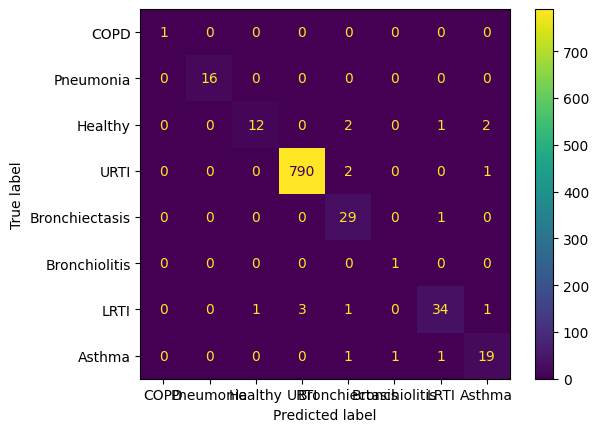

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay        // CHECK

cm_cnn=confusion_matrix(cnn_model_value.predict(x_test).argmax(axis=1),y_test.argmax(axis=1))
#
label_names = ['Pneumonia','Healthy','URTI','COPD','Bronchiectasis','Bronchiolitis','LRTI','Asthma' ]
# COPD              3965
# Pneumonia          185
# Healthy            175
# URTI               115
# Bronchiectasis      80
# Bronchiolitis       65
# LRTI                10
# Asthma               5

disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels = label_names)
disp.plot()
plt.show()

In [73]:

def calculate_display_precision(cnn_model, x_test, y_test):
    #Calculating and displaying the Precison, Recall and F1 score for each class
    preds = cnn_model.predict(x_test)
    y_actual = []
    y_pred = []

    labels = encode.classes_
    for idx, pred in enumerate(preds):
        y_actual.append(labels[np.argmax(y_test[idx])])
        y_pred.append(labels[np.argmax(pred)])

    print(classification_report(y_pred, y_actual))
    return [y_actual, y_pred]

In [74]:
y_actual_y_pred = calculate_display_precision(cnn_model_value, x_test, y_test)
y_actual = y_actual_y_pred[0]
y_pred = y_actual_y_pred[1]

29/29 [==============================] - 5s 176ms/step
                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00         1
Bronchiectasis       1.00      1.00      1.00        16
 Bronchiolitis       0.92      0.71      0.80        17
          COPD       1.00      1.00      1.00       793
       Healthy       0.83      0.97      0.89        30
          LRTI       0.50      1.00      0.67         1
     Pneumonia       0.92      0.85      0.88        40
          URTI       0.83      0.86      0.84        22

      accuracy                           0.98       920
     macro avg       0.87      0.92      0.89       920
  weighted avg       0.98      0.98      0.98       920



In [75]:

def plot_epoch_vs_train_test_accuracy_graph(cnn_history_history):
    #Plotting epoch vs Training and Testing accuracy Graph
    plt.figure(figsize=(16,6))
    plt.plot(cnn_history_history['accuracy'], color = "b")
    plt.plot(cnn_history_history['val_accuracy'], color = 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Accuracy','Testing Accuracy'],loc='upper left')

In [76]:
def plot_epoch_vs_train_test_loss_graph(cnn_history_history):
    #Plotting epoch vs Training and Testing loss Graph
    plt.figure(figsize=(16,8))
    plt.plot(cnn_history_history['loss'], color = "b")
    plt.plot(cnn_history_history['val_loss'], color="r")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training Loss','Testing Loss'],loc='upper right')


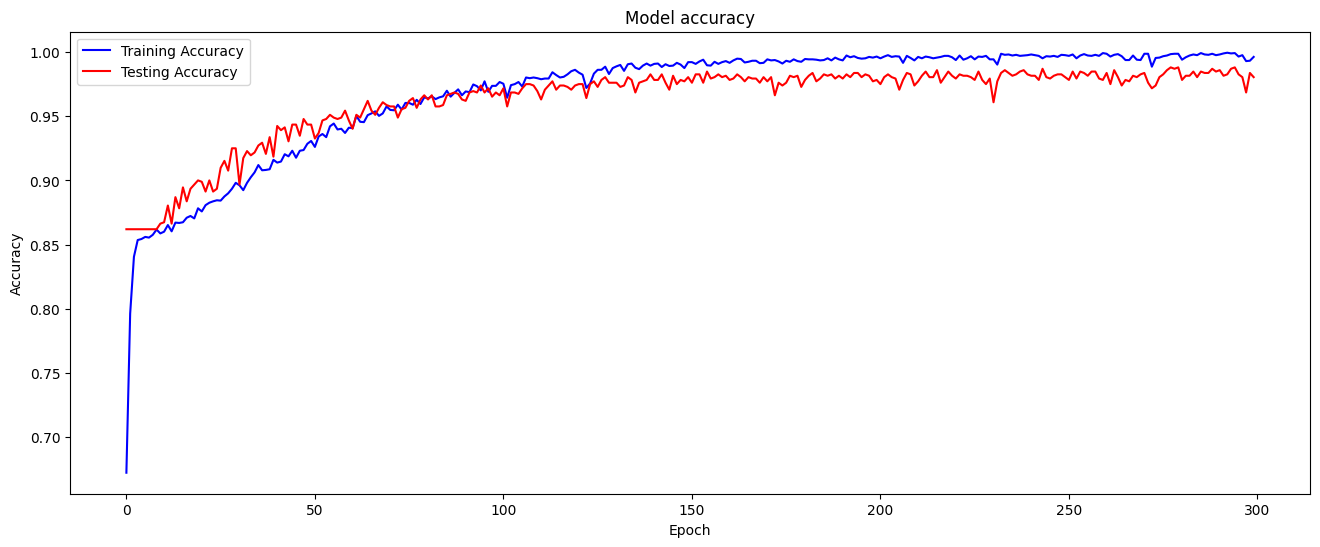

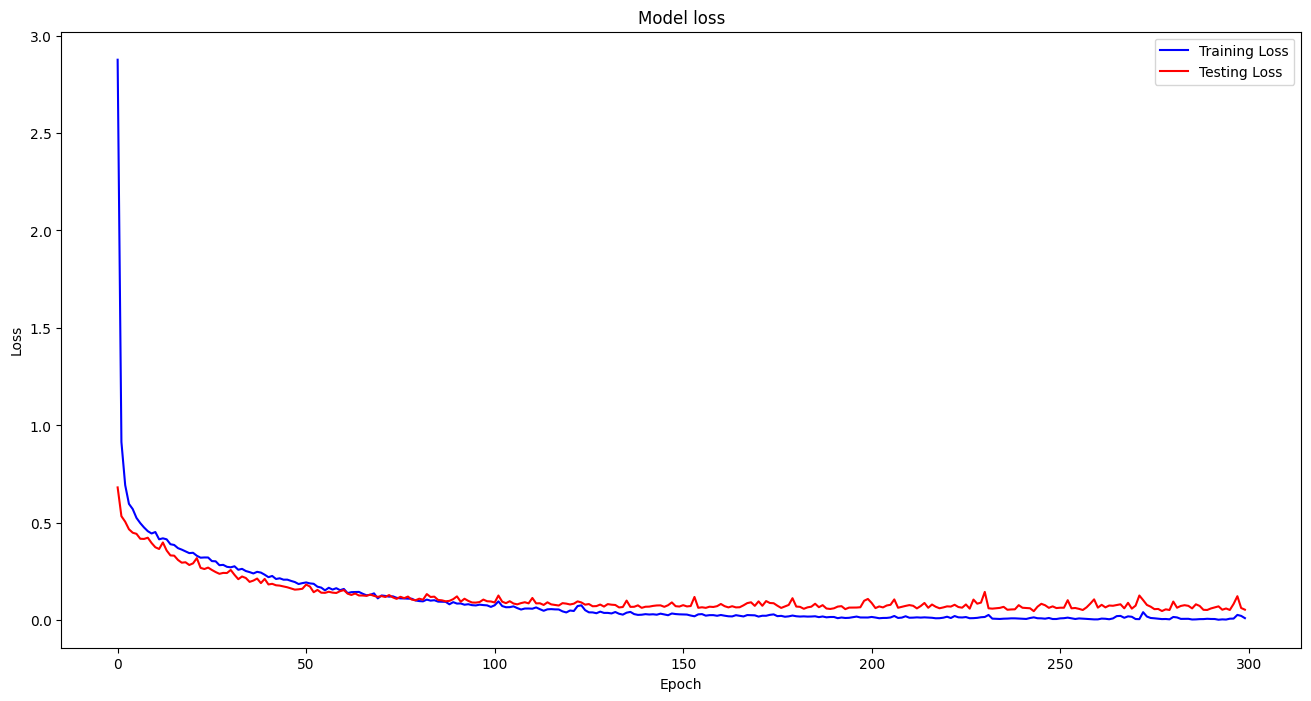

In [77]:

history = cnn_history.history #remove, temporary
#
plot_epoch_vs_train_test_accuracy_graph(history) #cnn_model_value.history.history
#
plot_epoch_vs_train_test_loss_graph(history)

In [78]:


def get_restored_model_accuracy(cnn_model_value, x_test, y_test):
    loss, acc = cnn_model_value.evaluate(x_test, y_test, verbose=2)
    return 'Restored model, accuracy: {:5.2f}%'.format(100 * acc)

In [79]:

def save_model(cnn_model_value, file_name): #save without extension or my_model.h5
    cnn_model_value.save(file_name)


In [80]:

def get_model_from_file(file_path): #return in tensorflow format
    fetched_model = tf.keras.models.load_model(file_path)
    return fetched_model

In [85]:

# #
# os.chdir(data_path)
# os.mkdir('saved_model')
# #ensure you are in the directory you want to save file
# save_model(cnn_model_value, 'my_model.h5')
#  #e.g. my_model.h5 so if you save a model in any type apart from h5 here on google colab you are likely to get it in a folder containing variables ,assets and other meta data


# #get cnn_model from saved model if you don't want to run a new training
# new_model_frm_memory = get_model_from_file('/saved/my_model.h5')

# #just to check the architecture of your model
# new_model.summary()


In [82]:

def convert_model_to_tflite(file_name):
    keras_model = tf.keras.models.load_model(file_name) #my_model.h5
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    converter.experimental_new_converter = True
    tflite_model = converter.convert()
    open(file_name+".tflite", "wb").write(tflite_model)


In [83]:
#convert training to tflite
convert_model_to_tflite('my_model.h5')

In [84]:



restored_model_accuracy = get_restored_model_accuracy(cnn_model_value, x_test, y_test)
print(restored_model_accuracy + '\n')


29/29 - 4s - loss: 0.0546 - accuracy: 0.9804 - 4s/epoch - 139ms/step
Restored model, accuracy: 98.04%

